# Library

In [ ]:
pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 75.6 MB/s eta 0:00:00


In [ ]:
#pip install tensorflow-gpu==2.1

In [ ]:
#pip install keras

# Data loader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

DATA = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/train.csv'
DEV_DATA = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/val.csv'
TEST_DATA = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

print(len(train_data))
print(len(dev_data))
print(len(test_data))

X_train = train_data['Comment']
y_train = train_data['Label'].values

X_dev = dev_data['Comment']
y_dev = dev_data['Label'].values

X_test = test_data['Comment']
y_test = test_data['Label'].values

5665
809
1619


In [ ]:
import pandas as pd
import numpy as np

from pyvi.ViTokenizer import ViTokenizer

STOPWORDS = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    #text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

In [ ]:
# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

# Run models

## Text CNN (Convolutional neural network for text classification)

In [ ]:
import keras
print(keras.__version__)

2.12.0


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Text CNN
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing import text, sequence
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [ ]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

#EMBEDDING_FILE = '/content/drive/MyDrive/MachineLearning/word2vec_vi_syllables_300dims.txt'
EMBEDDING_FILE = '/content/drive/MyDrive/MachineLearning/FinalTerm/TextCNN/word2vec_vi_words_300dims.txt'
MODEL_FILE = '/content/drive/MyDrive/MachineLearning/FinalTerm/TextCNN/Text_CNN_model_v13(Phow2v_Syllable).h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    #X = sequence.pad_sequences(X, maxlen=sequence_length)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

In [ ]:
# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)

In [ ]:
#with open('drive/My Drive/CODE/HSD/tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [ ]:
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     1357800     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 100, 300, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 99, 1, 32)    19232       ['reshape[0][0]']                
                                                                                              

### Syllable

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


23/23 [==============================] - 14s 57ms/step - loss: 1.0252 - accuracy: 0.6358 - val_loss: 0.9633 - val_accuracy: 0.7515
Epoch 2/40
23/23 [==============================] - 0s 19ms/step - loss: 0.8982 - accuracy: 0.7788 - val_loss: 0.8638 - val_accuracy: 0.7515
Epoch 3/40
23/23 [==============================] - 0s 19ms/step - loss: 0.8006 - accuracy: 0.7772 - val_loss: 0.7835 - val_accuracy: 0.7515
Epoch 4/40
23/23 [==============================] - 0s 21ms/step - loss: 0.7234 - accuracy: 0.7786 - val_loss: 0.7241 - val_accuracy: 0.7515
Epoch 5/40
23/23 [==============================] - 0s 20ms/step - loss: 0.6677 - accuracy: 0.7797 - val_loss: 0.6814 - val_accuracy: 0.7515
Epoch 6/40
23/23 [==============================] - 0s 20ms/step - loss: 0.6247 - accuracy: 0.7831 - val_loss: 0.6483 - val_accuracy: 0.7565
Epoch 7/40
23/23 [==============================] - 0s 20ms/step - loss: 0.5964 - accuracy: 0.7917 - val_loss: 0.6202 - val_accuracy: 0.7602
Epoch 8/40
23/23 [=====

<Axes: >

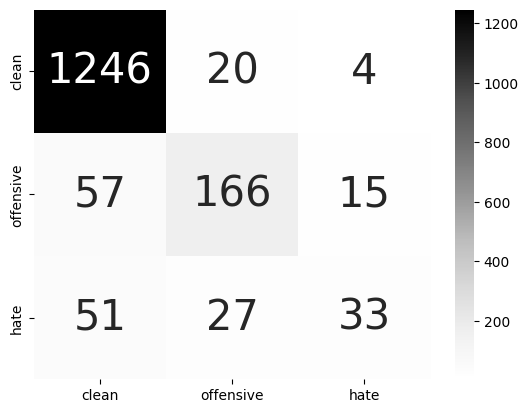

In [ ]:
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

### Testing for syllable

In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] != test_y[i]:
      print(test_data['Comment'][i], '|',y_pred[i] , '|', test_y[i])

se mấy bữa_nay giả fan trung_lập đi nhục kinh lắm | 0 | 2
bình_luận_viên hơi lạnh phải🤣🤣🤣 | 0 | 2
híu thảo đồ | 0 | 2
đá | 1 | 0
who need dev 1 ve: v | 0 | 2
mày đánh lux cặc | 0 | 2
??? huy bú | 0 | 2
đặc cầu | 0 | 1
aduvipwa | 0 | 1
zeus non học 369:)))) | 0 | 2
ys cặc | 0 | 2
2 đội gà v | 0 | 2
bọn như cặc già | 1 | 0
mẹ dink 140 | 0 | 1
nizy nhon vãi lồn =)) | 1 | 2
mấy hề đánh | 0 | 2
quang hải thịt trih trâu | 0 | 2
cưỡi con_bé awesome | 0 | 2
duma rừng | 0 | 1
sài_gòn lạnh chúng_mày chẳng hiểu sao đá | 0 | 2
red hút đá s | 0 | 2
lồn out trình sea | 1 | 0
đù 18 | 1 | 0
na hành máy quen =)) | 0 | 2
diana điên | 1 | 2
đéo tự_tin | 0 | 1
7 tạ | 2 | 0
xin_lỗi | 1 | 0
mẹ sp hoài | 0 | 1
lê khánh vô_học | 0 | 2
chấn bé đù | 1 | 2
mấy mấy đánh nhảy đầu cổ ta mắng_chửi v, cổ_vũ kệ văn_minh đi🥰 xấu hình_ảnh vãi cặc | 0 | 1
ngài điên | 1 | 2
quốc nhục gân đàm | 0 | 1
lồn magnus xoay vòng | 0 | 1
đi rừng ngu nh chó | 2 | 1
trụ rồng, chiến_thuật bọn gân đàm | 0 | 2
địt mẹ ghép ghép 3 đấy awe

In [ ]:
excel_file = '/content/drive/MyDrive/MachineLearning/Data/wrong(label).xlsx'

In [ ]:
# Ghi DataFrame vào file Excel
y_preded = pd.DataFrame(y_pred)
y_preded.to_excel(excel_file, index=False)

### Word

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


23/23 [==============================] - 13s 66ms/step - loss: 1.0342 - accuracy: 0.5719 - val_loss: 0.9762 - val_accuracy: 0.7503
Epoch 2/40
23/23 [==============================] - 1s 25ms/step - loss: 0.9110 - accuracy: 0.7728 - val_loss: 0.8779 - val_accuracy: 0.7515
Epoch 3/40
23/23 [==============================] - 1s 24ms/step - loss: 0.8131 - accuracy: 0.7762 - val_loss: 0.7991 - val_accuracy: 0.7515
Epoch 4/40
23/23 [==============================] - 1s 24ms/step - loss: 0.7388 - accuracy: 0.7763 - val_loss: 0.7396 - val_accuracy: 0.7515
Epoch 5/40
23/23 [==============================] - 1s 26ms/step - loss: 0.6875 - accuracy: 0.7762 - val_loss: 0.6990 - val_accuracy: 0.7515
Epoch 6/40
23/23 [==============================] - 1s 31ms/step - loss: 0.6457 - accuracy: 0.7769 - val_loss: 0.6665 - val_accuracy: 0.7515
Epoch 7/40
23/23 [==============================] - 1s 30ms/step - loss: 0.6137 - accuracy: 0.7793 - val_loss: 0.6387 - val_accuracy: 0.7515
Epoch 8/40
23/23 [=====

<Axes: >

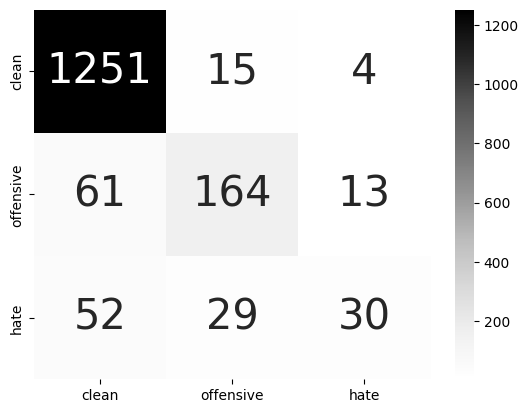

In [ ]:
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] != test_y[i]:
      print(test_data['Comment'][i], '|',y_pred[i] , '|', test_y[i])

se mấy bữa_nay giả fan trung_lập đi nhục kinh lắm | 0 | 2
bình_luận_viên hơi lạnh phải🤣🤣🤣 | 0 | 2
híu thảo đồ | 0 | 2
who need dev 1 ve: v | 0 | 2
mày đánh lux cặc | 0 | 2
??? huy bú | 0 | 2
đặc cầu | 0 | 1
aduvipwa | 0 | 1
bé đần =]] | 1 | 2
zeus non học 369:)))) | 0 | 2
ys cặc | 1 | 2
2 đội gà v | 0 | 2
bọn như cặc già | 1 | 0
rên đi | 0 | 1
mẹ dink 140 | 0 | 1
nizy nhon vãi lồn =)) | 1 | 2
mấy hề đánh | 0 | 2
quang hải thịt trih trâu | 0 | 2
cưỡi con_bé awesome | 0 | 2
duma rừng | 0 | 1
sài_gòn lạnh chúng_mày chẳng hiểu sao đá | 0 | 2
red hút đá s | 0 | 2
lồn out trình sea | 1 | 0
đạn, firerate chậm, giật, spam lộ đường_đạn... như cặc cân_bằng. rito said: d | 1 | 0
ngu câm | 2 | 1
moá đánh bắt | 0 | 1
na hành máy quen =)) | 0 | 2
diana điên | 1 | 2
mẹ sp hoài | 0 | 1
lê khánh vô_học | 0 | 2
chấn bé đù | 1 | 2
vcs rác | 1 | 2
ngài điên | 1 | 2
quốc nhục gân đàm | 0 | 1
lồn magnus xoay vòng | 0 | 1
200 ntr clgt awesome | 0 | 1
đi rừng ngu nh chó | 2 | 1
trụ rồng, chiến_thuật bọn gân đ